In [1]:
import numpy as np
import open3d as o3d
import json
import os
from tqdm import tqdm
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib import rcParams
import statistics as st
from sklearn.model_selection import GridSearchCV

from pyquaternion import Quaternion
import os.path as osp

from sklearn.decomposition import PCA
from sklearn.multioutput import MultiOutputRegressor

from nuscenes.nuscenes import NuScenes
from nuscenes.utils.data_classes import Box
from utils.vis import plot_3d_image_
from utils.misc import *

%matplotlib inline

In [2]:
nusc = NuScenes(version='v1.0-mini', dataroot='/home/gus/Documents/AI_S/nuScenes/v1_0-mini', verbose=True)
#nusc = NuScenes(version='v1.0-mini', dataroot='/home/sherlock/Documents/nuScenes/data', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 1.9 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


## CSV creation

The following two cells must be executed only when the CSV file needs to be created

In [3]:
# Computing the maximum number of points in a segmented pointcloud

# path with all the sample files
samples_path =  os.getcwd() + '/dataset/samples/'

min_points = 1000 # Smalles pcl
max_points = 0 # Biggest pcl

# extract all files in path
for root, dirs, files in os.walk(samples_path):
    
    # select each sample file
    for file_ in tqdm(files, desc = "Sample files"):    
        
        # load the current sample file
        data_json = load_file(samples_path + file_)
                
        # process each instance
        for idx in range(len(data_json['instance'])):
            
            # Create instance metadata
            annotation_metadata = data_json['instance'][idx]
                        
            # Read segmented point cloud
            pcd = o3d.io.read_point_cloud(annotation_metadata['pcd_path'])
            
            N = np.asarray(pcd.points).shape[0]
            
            # Store the minimum and maximum numbers of points in the point cloud
            if N < min_points:
                min_points = N
                
            if N > max_points:
                max_points = N
            
print('The maximum number of points in a point clouds are: {}'.format(max_points))
print('The maximum number of points in a point clouds are: {}'.format(min_points))

Sample files: 100%|██████████| 404/404 [00:00<00:00, 1794.62it/s]

The maximum number of points in a point clouds are: 2016
The maximum number of points in a point clouds are: 30


## Temporal points matrix

The next cell creates a temporal matrix to store the features of all the instances to apply PCA.

In [4]:
# path with all the sample files
samples_path =  os.getcwd() + '/dataset/samples/'

# path to retrieve point clous features
features_path =  os.getcwd() + '/dataset/point_features_path/'

# Segmented pointd cloud paths
segmentation_path =  os.getcwd() + '/dataset/pcd_segmentation/'

# Matrix to store X components
x = []
# Matrix to store Y components
y = []
# Matrix to store Z components
z = []

# Maximum number of points allowed in the array
M = max_points

# extract all files in path
for root, dirs, files in os.walk(samples_path):
    
    # select each sample file
    for file_ in tqdm(files, desc = "Sample files"):    
        
        # load the current sample file
        data_json = load_file(samples_path + file_)
                
        # process each instance
        for idx in range(len(data_json['instance'])):
            
            # Create instance metadata
            annotation_metadata = data_json['instance'][idx]
            #print(annotation_metadata['sample_token'])
                        
            # Read segmented point cloud
            pcd = o3d.io.read_point_cloud(annotation_metadata['pcd_path'])
            
            N = np.asarray(pcd.points).shape[0]     
            
            # Save the point cloud as a numpy array
            points_xyz = np.asarray(pcd.points)
            
            temp_points = np.zeros((M, 3))
            temp_points[:points_xyz.shape[0], :] = points_xyz
            
            #print(points_xyz[:, 0].shape)
            
            # Append the points to the lists
            x.append(temp_points[:, 0])
            y.append(temp_points[:, 1])
            z.append(temp_points[:, 2])


# Transform the lists into numpy array for future use
x = np.array(x)
y = np.array(y)
z = np.array(z)

print('The shape of the x coordinates array is: {}'.format(x.shape))
print('The shape of the x coordinates array is: {}'.format(y.shape))
print('The shape of the x coordinates array is: {}'.format(z.shape))

Sample files: 100%|██████████| 404/404 [00:00<00:00, 1592.59it/s]

The shape of the x coordinates array is: (1411, 2016)
The shape of the x coordinates array is: (1411, 2016)
The shape of the x coordinates array is: (1411, 2016)


### Computing the dot product between the LiDAR frame and point cloud orientation

In [5]:
# keep the first principal components of the data for each axis
pca_x = PCA(n_components = 1) 
pca_y = PCA(n_components = 1) 
pca_z = PCA(n_components = 1) 
# fit PCA model to each component of the point cloud
pca_x.fit(x) 
pca_y.fit(y) 
pca_z.fit(z) 
# transform data onto the first principal components 
X_pca = pca_x.transform(x) 
Y_pca = pca_y.transform(y) 
Z_pca = pca_z.transform(z)

print("Original shape of X: {}".format(str(x.shape)))
print("Reduced shape of X: {}".format(str(X_pca.shape)))

# As much components as original features
print('PCA component shape: {}'.format(pca_x.components_.shape))
# There are one value in componentes (per feature), the first principal
print('PCA component: {}'.format(pca_x.components_))
# Text one PCA value for X
idx = 75 # 120
print('The PCA value is: {}'.format(X_pca[idx, :]))

lidar = np.array([1, 0, 0]) # column vector
pcl_segmented = np.array([X_pca[idx, :], Y_pca[idx, :], Z_pca[idx, :]]).reshape(3)

print('The Lidar Vector is: {}'.format(lidar))
print('The point cloud principal components are: {}'.format(pcl_segmented))

dotProd = lidar.dot(pcl_segmented)
crossProd = np.linalg.norm(np.cross(lidar, pcl_segmented))
normProd= np.linalg.norm(lidar) * np.linalg.norm(pcl_segmented)
cos_angle = np.arccos(dotProd / normProd)
sin_ang = np.arcsin(crossProd / normProd)
tan_ang = np.arctan2(crossProd / normProd, dotProd / normProd)
opo_cos_ang = cos_angle - np.pi 

print('The arccos value of a simple sample is: {}'.format(cos_angle))
print('The arcsin value of a simple sample is: {}'.format(sin_ang))
print('The arctan2 value of a simple sample is: {}'.format(tan_ang))
print('The opposite angle value of a simple sample is: {}'.format(opo_cos_ang))

Original shape of X: (1411, 2016)
Reduced shape of X: (1411, 1)
PCA component shape: (1, 2016)
PCA component: [[0.07711434 0.07777395 0.07763953 ... 0.00014264 0.00015825 0.00017076]]
The PCA value is: [69.66544936]
The Lidar Vector is: [1 0 0]
The point cloud principal components are: [69.66544936  2.46596378 12.70902456]
The arccos value of a simple sample is: 0.18373587754757567
The arcsin value of a simple sample is: 0.18373587754757512
The arctan2 value of a simple sample is: 0.18373587754757512
The opposite angle value of a simple sample is: -2.9578567760422176


## Loop to create the features and targets file

The CSV file has the targets, features, and useful metadata to plot the instance of interest, class, etc.

In [8]:
# path with all the sample files
samples_path =  os.getcwd() + '/dataset/samples/'

# path to retrieve point clous features
features_path =  os.getcwd() + '/dataset/point_features_path/'

# Matrix to store the features' vectors
features_matrix = []
# Dictionary of targets
targets_dic = {'x_pos': [], 'y_pos': [], 'z_pos': [], 'width': [], 'lenght': [], 'height': [], 'yaw': []}

tokens_dic = {'sample_token': [], 'camera_token': [], 'category': []}

# Vectors to compute orientations
vec_x = np.array([1, 0, 0]) 
vec_y = np.array([0, 1, 0]) 
vec_z = np.array([0, 0, 1]) 

# extract all files in path
for root, dirs, files in os.walk(samples_path):
    
    # select each sample file
    for file_ in tqdm(files, desc = "Sample files"):    
        
        # load the current sample file
        data_json = load_file(samples_path + file_)
                
        # process each instance
        for idx in range(len(data_json['instance'])):
            
            # Create instance metadata
            annotation_metadata = data_json['instance'][idx]
            
            # Point cloud
            pcd = o3d.io.read_point_cloud(annotation_metadata['pcd_path'])            
            
            pointcloud = np.asarray(pcd.points).T
            
            # Mean
            mean_x = st.mean(pointcloud[0,:])
            mean_y = st.mean(pointcloud[1,:])
            mean_z = st.mean(pointcloud[2,:])
            
            # Median
            median_x = st.median(pointcloud[0,:])
            median_y = st.median(pointcloud[1,:])
            median_z = st.median(pointcloud[2,:])
            
            # Middle
            middle_x = middle_func(pointcloud[0,:])
            middle_y = middle_func(pointcloud[1,:])
            middle_z = middle_func(pointcloud[2,:])            

            # Retrieve instance's features
            features_vec = parse_features_to_numpy(annotation_metadata['point_features_path'])
            
            # matrix with the points arranged as M x 3
            points_xyz = np.asarray(pcd.points)
            # Arrange the points in a fixed size in such way that the missing values are filled with zeroes
            temp_points = np.zeros((M, 3))
            temp_points[:points_xyz.shape[0], :] = points_xyz
            
            # Computing angles
            X_pca = pca_x.transform(temp_points[:, 0].reshape(1, -1)).squeeze()
            Y_pca = pca_y.transform(temp_points[:, 1].reshape(1, -1)).squeeze()
            Z_pca = pca_z.transform(temp_points[:, 2].reshape(1, -1)).squeeze()
            
            # Construct point cloud vector
            pcl_vec = np.array([X_pca, Y_pca, Z_pca])
            
            # dot, cross and norm product for x axis
            dotProd_x = vec_x.dot(pcl_vec)
            crossProd_x = np.linalg.norm(np.cross(vec_x, pcl_vec))
            normProd_x = np.linalg.norm(vec_x) * np.linalg.norm(pcl_vec)
            
            # dot, cross and norm product for y axis
            dotProd_y = vec_y.dot(pcl_vec)
            crossProd_y = np.linalg.norm(np.cross(vec_y, pcl_vec))
            normProd_y = np.linalg.norm(vec_y) * np.linalg.norm(pcl_vec)
            
            # dot, cross and norm product for z axis
            dotProd_z = vec_z.dot(pcl_vec)
            crossProd_z = np.linalg.norm(np.cross(vec_z, pcl_vec))
            normProd_z = np.linalg.norm(vec_z) * np.linalg.norm(pcl_vec)            
            
            # Compute the cos values for each axis
            roll_x = np.arccos( dotProd_x / (normProd_x))
            pitch_y = np.arccos( dotProd_y / (normProd_y))
            yaw_z = np.arccos( dotProd_z / (normProd_z))
            
            # Compute oposite cos values  
            opo_roll_x = roll_x - np.pi
            opo_pitch_y = pitch_y - np.pi
            opo_yaw_z = yaw_z - np.pi                   
            
            # Add mean meadian and middle to features matrix
            features_vec = np.hstack([features_vec, mean_x, mean_y, mean_z, median_x, 
                                      median_y, median_z, middle_x, middle_y, middle_z, roll_x,
                                     pitch_y, yaw_z, -roll_x, -pitch_y, -yaw_z,opo_roll_x,
                                     opo_pitch_y,opo_yaw_z])
                                     #np.pi - roll_x, np.pi - pitch_y, np.pi - yaw_z,
                                     #roll_x - np.pi, pitch_y - np.pi, yaw_z - np.pi])
            
            # Store the current feature vector in the features' matrix
            features_matrix.append(list(features_vec))
            
            # Extract class targets
            pose = annotation_metadata['position_coord']
            dims = annotation_metadata['wlh_values']
            yaw = annotation_metadata['orientation_value']
            label = annotation_metadata['category']
            
            # Save X, Y and Z pose
            targets_dic['x_pos'].append(pose[0])
            targets_dic['y_pos'].append(pose[1])
            targets_dic['z_pos'].append(pose[2])
            
            # Store target size
            targets_dic['width'].append(dims[0])
            targets_dic['lenght'].append(dims[1])
            targets_dic['height'].append(dims[2])
            
            # Save the orientations in such way that the rotation matrix is always 1
            if annotation_metadata['rotation_axis'] > 0:
                # Store target orientation
                targets_dic['yaw'].append(yaw)
            else:
                targets_dic['yaw'].append(-yaw)
                
            
            # Store sample, camera and annotation token
            tokens_dic['sample_token'].append(annotation_metadata['sample_token'])
            tokens_dic['camera_token'].append(annotation_metadata['camera_token'])
            tokens_dic['category'].append(annotation_metadata['category'])
            
            
# Parse features as a numpy array
features_matrix = np.array(features_matrix)

# Create a dataframe of features
df_features = pd.DataFrame(data = features_matrix)
# Create a dataframe of targets
df_targets = pd.DataFrame.from_dict(targets_dic)
# Create a dataframe of tokens
df_tokens = pd.DataFrame.from_dict(tokens_dic)

# Concat both dataframes horizontally to create the final dataframe
df_detection = pd.concat([df_features, df_targets, df_tokens], axis=1)
df_detection.head()

df_detection.to_csv('dataset/3d_obj_detection.csv')

Sample files: 100%|██████████| 404/404 [00:04<00:00, 94.27it/s] 


## Loading CSV and parsing info as a numpy array

In [3]:
# Load dataframe form CSV file
df_detection_csv = pd.read_csv('dataset/3d_obj_detection.csv')
# features: 1 - 640 // targets: 641 - 648
        
print('The Dataframe shape is {}'.format(df_detection_csv.shape))
print('The targets keys are',df_detection_csv.keys()[659:666])
# Parse features and targets to numpy array\n",
features = df_detection_csv.loc[:,'0':'657'].to_numpy()
targets = df_detection_csv.loc[:,'x_pos':'category']
print('The Features shape is {}'.format(features.shape))
print('The Targets shape is {}'.format(targets.shape))

The Dataframe shape is (1411, 669)
The targets keys are Index(['x_pos', 'y_pos', 'z_pos', 'width', 'lenght', 'height', 'yaw'], dtype='object')
The Features shape is (1411, 658)
The Targets shape is (1411, 10)


## Splitting and scaling the data

In [4]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import RobustScaler 
from sklearn.preprocessing import Normalizer 

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=1)

print('Train set features size: \n {}'.format(X_train.shape))
print('Test set featires size: \n {}'.format(X_test.shape))
print('Train set targets size: \n {}'.format(y_train.shape))
print('Test set targets size: \n {}'.format(y_test.shape))

y_train_tokens = y_train.drop(['x_pos', 'y_pos', 'z_pos', 'width', 'lenght', 'height', 'yaw'], axis=1)
y_test_tokens =  y_test.drop(['x_pos', 'y_pos', 'z_pos', 'width', 'lenght', 'height', 'yaw'], axis=1)
y_train = y_train.loc[:,'x_pos':'yaw'].to_numpy()
y_test = y_test.loc[:,'x_pos':'yaw'].to_numpy()

# transform orientation from degres to rad
y_train_yaw = y_train[:, 6]
#y_train[:, 6] = (np.sin(np.deg2rad(y_train_yaw))*2)+2
y_train[:, 6] = np.deg2rad(y_train_yaw)

y_test_yaw = y_test[:, 6]
#y_test[:, 6] = (np.sin(np.deg2rad(y_test_yaw))*2)+2
y_test[:, 6] = np.deg2rad(y_test_yaw)

Train set features size: 
 (1128, 658)
Test set featires size: 
 (283, 658)
Train set targets size: 
 (1128, 10)
Test set targets size: 
 (283, 10)


## Transformation

In [5]:
scaler = MinMaxScaler()
scaler.fit(X_train) 
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

---
### Grid Search for SVR 

In [12]:
from sklearn.svm import SVR
tuned_parameters = [{'estimator__kernel': ['linear', 'poly', 'rbf'], 
                     'estimator__C': [1,0.5],
                     'estimator__epsilon': [1,0.1]}]

svr_mo = MultiOutputRegressor(SVR())

gs_svr = GridSearchCV(svr_mo, tuned_parameters)
gs_svr.fit(X_train_scaled, y_train)

print("Best Hyperparameters found are:")
print(gs_svr.best_params_)

means = gs_svr.cv_results_['mean_test_score']
for mean,params in zip(means, gs_svr.cv_results_['params']):
  print("%0.3f for %r" % (mean, params))

# Best Hyperparameters conbination
#0.713 for {'estimator__C': 1, 'estimator__epsilon': 0.1, 'estimator__kernel': 'poly'}

Best Hyperparameters found are:
{'estimator__C': 1, 'estimator__epsilon': 0.1, 'estimator__kernel': 'poly'}
0.508 for {'estimator__C': 1, 'estimator__epsilon': 1, 'estimator__kernel': 'linear'}
0.471 for {'estimator__C': 1, 'estimator__epsilon': 1, 'estimator__kernel': 'poly'}
0.372 for {'estimator__C': 1, 'estimator__epsilon': 1, 'estimator__kernel': 'rbf'}
0.675 for {'estimator__C': 1, 'estimator__epsilon': 0.1, 'estimator__kernel': 'linear'}
0.706 for {'estimator__C': 1, 'estimator__epsilon': 0.1, 'estimator__kernel': 'poly'}
0.631 for {'estimator__C': 1, 'estimator__epsilon': 0.1, 'estimator__kernel': 'rbf'}
0.507 for {'estimator__C': 0.5, 'estimator__epsilon': 1, 'estimator__kernel': 'linear'}
0.450 for {'estimator__C': 0.5, 'estimator__epsilon': 1, 'estimator__kernel': 'poly'}
0.308 for {'estimator__C': 0.5, 'estimator__epsilon': 1, 'estimator__kernel': 'rbf'}
0.683 for {'estimator__C': 0.5, 'estimator__epsilon': 0.1, 'estimator__kernel': 'linear'}
0.683 for {'estimator__C': 0.5,

### Scores with best Hyperparameters for SVR

In [8]:
from sklearn.svm import SVR

svr_mo = MultiOutputRegressor(SVR(C = 1, epsilon = 0.1, kernel = 'poly'))
svr_mo.fit(X_train_scaled, y_train)

print('Training set score is: {:.3f}'.format(svr_mo.score(X_train_scaled, y_train)))
print('Test set score is: {:.3f}'.format(svr_mo.score(X_test_scaled, y_test)))

Training set score is: 0.854
Test set score is: 0.715


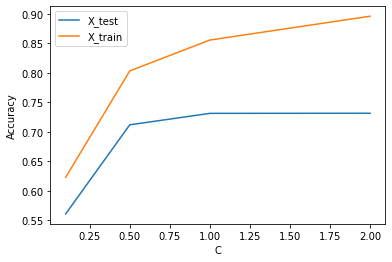

In [17]:
c_range = [2,1,0.5,0.1]
scores_test = []
scores_train=[]

for c in c_range:
    model_svr = svr_mo = MultiOutputRegressor(SVR(C = c, epsilon = 0.1, kernel = 'poly'))
    model_svr.fit(X_train_scaled, y_train)
    scores_test.append(model_svr.score(X_test_scaled, y_test))
    scores_train.append(model_svr.score(X_train_scaled, y_train))

plt.xlabel('C')
plt.ylabel('Accuracy')

plt.plot(c_range, scores_test)
plt.plot(c_range, scores_train)
plt.legend(('X_test','X_train'))

---
### Grid Search for Lasso

In [13]:
from sklearn import linear_model

tuned_parameters = [{'estimator__normalize': [True, False], 
                     'estimator__alpha': [1,0.5,0.005,0.001]}]

m_lasso = MultiOutputRegressor(linear_model.Lasso(max_iter = 5000))

gs_lasso = GridSearchCV(m_lasso, tuned_parameters)
gs_lasso.fit(X_train_scaled, y_train)

print("Best Hyperparameters found are:")
print(gs_lasso.best_params_)

means = gs_lasso.cv_results_['mean_test_score']
for mean,params in zip(means, gs_lasso.cv_results_['params']):
  print("%0.3f for %r" % (mean, params))

# Best Hyperparameters conbination
#0.692 for {'estimator__alpha': 0.001, 'estimator__normalize': False}

Best Hyperparameters found are:
{'estimator__alpha': 0.001, 'estimator__normalize': False}
-0.004 for {'estimator__alpha': 1, 'estimator__normalize': True}
0.175 for {'estimator__alpha': 1, 'estimator__normalize': False}
-0.004 for {'estimator__alpha': 0.5, 'estimator__normalize': True}
0.228 for {'estimator__alpha': 0.5, 'estimator__normalize': False}
0.585 for {'estimator__alpha': 0.005, 'estimator__normalize': True}
0.681 for {'estimator__alpha': 0.005, 'estimator__normalize': False}
0.679 for {'estimator__alpha': 0.001, 'estimator__normalize': True}
0.683 for {'estimator__alpha': 0.001, 'estimator__normalize': False}


### Scores with best Hyperparameters for Lasso

In [7]:
from sklearn import linear_model

m_lasso = MultiOutputRegressor(linear_model.Lasso(max_iter = 5000, alpha = 0.001, normalize = False))

m_lasso.fit(X_train_scaled, y_train)

print('Training set score is: {:.3f}'.format(m_lasso.score(X_train_scaled, y_train)))
print('Test set score is: {:.3f}'.format(m_lasso.score(X_test_scaled, y_test)))

Training set score is: 0.794
Test set score is: 0.674


---
### Grid Search for RandomForestRegressor 

In [7]:
from sklearn.ensemble import RandomForestRegressor

tuned_parameters = [{ 'criterion' : ['mse', 'mae'], 
                     'n_estimators': [50,100]}]

rfr = RandomForestRegressor(random_state = 123)

gs_rfr = GridSearchCV(rfr, tuned_parameters)
gs_rfr.fit(X_train_scaled, y_train)

print("Best Hyperparameters found are:")
print(gs_rfr.best_params_)

means = gs_rfr.cv_results_['mean_test_score']
for mean,params in zip(means, gs_rfr.cv_results_['params']):
  print("%0.3f for %r" % (mean, params))

# Best Hyperparameters conbination
#0.744 for {'criterion': 'mae', 'n_estimators': 100}

Best Hyperparameters found are:
{'criterion': 'mae', 'n_estimators': 100}
0.730 for {'criterion': 'mse', 'n_estimators': 50}
0.735 for {'criterion': 'mse', 'n_estimators': 100}
0.743 for {'criterion': 'mae', 'n_estimators': 50}
0.744 for {'criterion': 'mae', 'n_estimators': 100}


### Scores with best Hyperparameters for Random Forest

In [9]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(random_state = 123,criterion = 'mae', n_estimators = 100)
rfr.fit(X_train_scaled, y_train)

print('Training set score is: {:.3f}'.format(rfr.score(X_train_scaled, y_train)))
print('Test set score is: {:.3f}'.format(rfr.score(X_test_scaled, y_test)))

Training set score is: 0.965
Test set score is: 0.715


---
## Visualizing 3D plot

Predicted values:  [[-0.18524659 -8.21791059 -1.17639771  1.98904419  4.82938988  1.97909914
   1.56096473]]
Ground truth values:  [-0.13918005 -7.98530352 -1.1263937   1.979       4.782       1.954
  1.55380465]


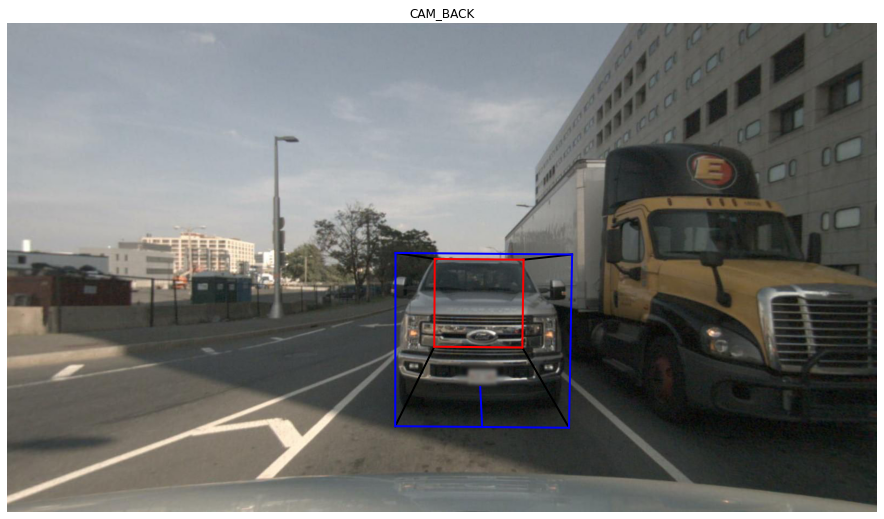

In [86]:
# sample index to predict 
idx = 92# Idx test max 283

# Make a prediction with random forest model
pred_test = svr_mo.predict(X_test_scaled[idx, :].reshape(1, -1))

# Extract relevant info of the prediction
fast_test = y_test_tokens.to_numpy()
sample_token, cam_token, label = fast_test[idx, :]

# Compare ground truth vs prediction
print('Predicted values: ',pred_test)
print('Ground truth values: ',y_test[idx, :])

# Create a Quaternion with the orientation of the predicted vehicle
q0 = Quaternion(axis=[0, 0, 1], angle = pred_test[0][6])
# Create the bounding box object 
bbox = Box(pred_test[0][:3], pred_test[0][3:6], q0, name = label,token = sample_token)
# Plot the results
plot_3d_image_(nusc, cam_token, label, sample_token, bbox)